In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# Load the dataset
file_path = 'Ethereum Historical Data.csv'  # Update the path if needed

df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index('Date', inplace=True)
df = df.sort_index()
df = df.asfreq('D')
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df['Price'] = df['Price'].interpolate(method='linear')

# Extract the 'Price' column
price_data = df['Price']

# Split the data into training and testing
train_size = int(len(price_data) * 0.8)
train_data, test_data = price_data[:train_size], price_data[train_size:]

# Step 1: ARIMA Model for Trend Prediction
model_arima = ARIMA(train_data, order=(5, 1, 0))
model_arima_fit = model_arima.fit()
train_data_arima = model_arima_fit.fittedvalues
test_data_arima = model_arima_fit.forecast(steps=len(test_data))

# Step 2: Preparing Data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_original = MinMaxScaler(feature_range=(0, 1))

scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))
scaled_train_residuals = scaler.fit_transform((train_data - train_data_arima).values.reshape(-1, 1))
scaled_test_data = scaler_original.fit_transform(test_data.values.reshape(-1, 1))

# Function to prepare data for LSTM

def prepare_data(data, lookback):
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

# Prepare training data
lookback = 60
X_train_original, y_train_original = prepare_data(scaled_train_data, lookback)
X_train_residuals, y_train_residuals = prepare_data(scaled_train_residuals, lookback)

X_train_original = X_train_original.reshape((X_train_original.shape[0], X_train_original.shape[1], 1))
X_train_residuals = X_train_residuals.reshape((X_train_residuals.shape[0], X_train_residuals.shape[1], 1))

# Step 3: Optimized LSTM Model for Original Data
model_original = Sequential([
    Input(shape=(lookback, 1)),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

model_original.compile(optimizer='adam', loss='mean_squared_error')
model_original.fit(X_train_original, y_train_original, batch_size=32, epochs=30)

# Step 4: Optimized LSTM Model for Residuals
model_residuals = Sequential([
    Input(shape=(lookback, 1)),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

model_residuals.compile(optimizer='adam', loss='mean_squared_error')
model_residuals.fit(X_train_residuals, y_train_residuals, batch_size=32, epochs=30)

# Prepare testing data
actual_test_residuals = test_data - test_data_arima
scaled_test_residuals = scaler.transform(actual_test_residuals.values.reshape(-1, 1))

X_test_original, _ = prepare_data(scaled_test_data, lookback)
X_test_residuals, _ = prepare_data(scaled_test_residuals, lookback)

X_test_original = X_test_original.reshape((X_test_original.shape[0], X_test_original.shape[1], 1))
X_test_residuals = X_test_residuals.reshape((X_test_residuals.shape[0], X_test_residuals.shape[1], 1))

# Predicting with both models
pred_original = scaler_original.inverse_transform(model_original.predict(X_test_original))
pred_residuals = scaler.inverse_transform(model_residuals.predict(X_test_residuals))

# Step 5: Hyperparameter Optimized Ensemble Model
combined_input = np.column_stack((pred_original.flatten(), pred_residuals.flatten()))

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - loss: 0.0320
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 242ms/step - loss: 0.0026
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 244ms/step - loss: 0.0025
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - loss: 0.0035
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 0.0020
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 0.0025
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - loss: 0.0020
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - loss: 0.0016
Epoch 9/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 0.0016
Epoch 10/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - loss: 0.0017
Epoch 11/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - loss: 0.0015
Epoch 12/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - loss: 0.0022
Epoch 13/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - loss: 0.0015
Epoch 14/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - loss: 0.0013
Epoch 15/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step -


Evaluation for 3-day Prediction:
RMSE: 19.73083027373884
MSE: 389.3056632910891
MAE: 15.573833268228858
MAPE: 0.4329164673448977%
R²: 0.9134935696335921

Evaluation for 7-day Prediction:
RMSE: 30.24571661662335
MSE: 914.8033736530858
MAE: 25.90222232142748
MAPE: 0.7677792773434419%
R²: 0.9451525743628096

Evaluation for 30-day Prediction:
RMSE: 40.31103513694092
MSE: 1624.9795538116857
MAE: 30.25381300130137
MAPE: 0.9157769134440882%
R²: 0.9543208606017071


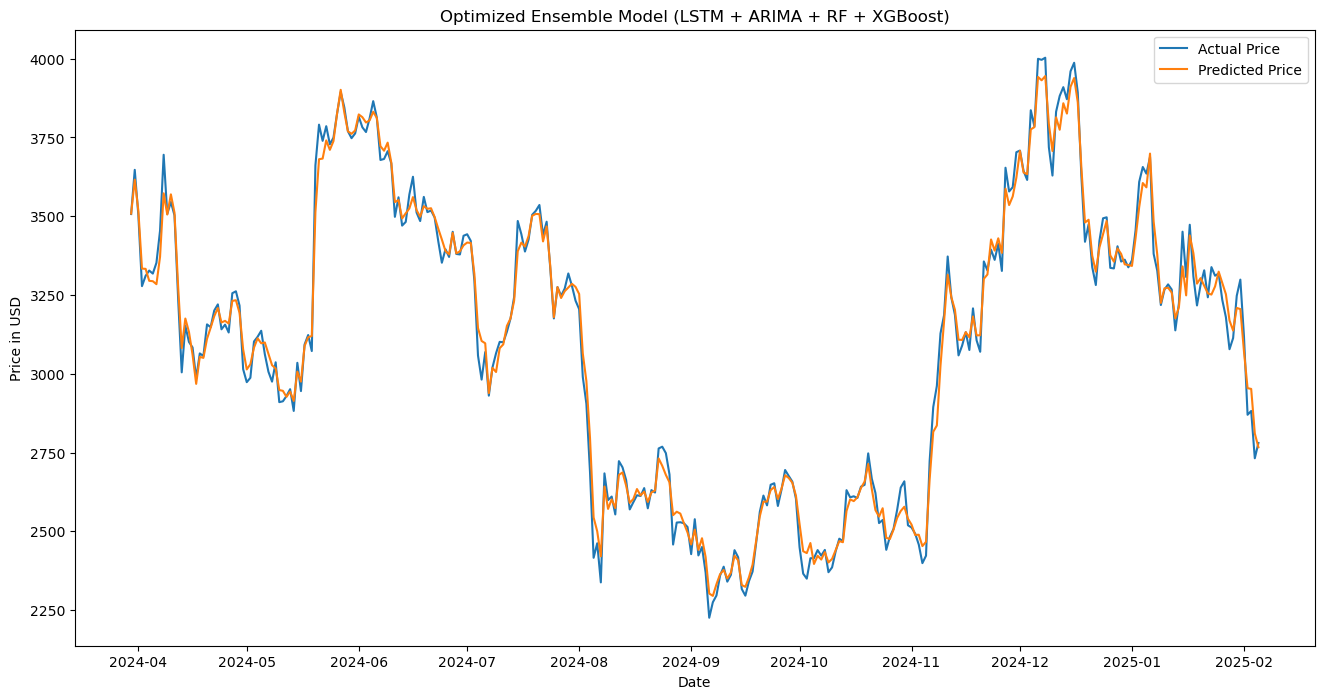

In [7]:
# Step 6: Train the Ensemble Models and Save Them
import joblib

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(combined_input, test_data[-len(combined_input):])
joblib.dump(rf_model, 'random_forest_model.pkl')  # Saving the RandomForest model

# XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(combined_input, test_data[-len(combined_input):])
joblib.dump(xgb_model, 'xgboost_model.pkl')  # Saving the XGBoost model

# Step 7: Making Predictions with the Ensemble Models
rf_predictions = rf_model.predict(combined_input)
xgb_predictions = xgb_model.predict(combined_input)

# Average of predictions from Random Forest and XGBoost (Ensemble Prediction)
predicted_prices = (rf_predictions + xgb_predictions) / 2

# Convert predictions to a Pandas Series for compatibility
predicted_prices = pd.Series(predicted_prices, index=test_data.index[-len(predicted_prices):])

# Step 8: Evaluate Metrics for 3-day, 7-day, and 30-day Predictions
for days in [3, 7, 30]:
    if days <= len(predicted_prices):
        metrics = evaluate_metrics(test_data[-len(predicted_prices):][:days], predicted_prices[:days])
        print(f"\nEvaluation for {days}-day Prediction:")
        print(f"RMSE: {metrics[0]}")
        print(f"MSE: {metrics[1]}")
        print(f"MAE: {metrics[2]}")
        print(f"MAPE: {metrics[3]}%")
        print(f"R²: {metrics[4]}")
    else:
        print(f"\nSkipping evaluation for {days}-day Prediction as not enough data points are available.")

# Plotting the results
plt.figure(figsize=(16, 8))
plt.plot(test_data.index[-len(predicted_prices):], test_data[-len(predicted_prices):], label='Actual Price')
plt.plot(test_data.index[-len(predicted_prices):], predicted_prices, label='Predicted Price')
plt.title('Optimized Ensemble Model (LSTM + ARIMA + RF + XGBoost)')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()
